# Data Preparation

In [1]:
from torchvision.datasets import ImageFolder
import os

In [2]:
%pwd

'f:\\end-to-end-deep_learning-project\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'f:\\end-to-end-deep_learning-project'

## Apply transforms

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [6]:
dataset = ImageFolder("artifacts\data_ingestion",transform=transform)

In [7]:
len(dataset)

557

## Class names (folder names)

In [8]:
dataset.classes

['cats', 'dogs']

## Class-to-index mapping

In [9]:
dataset.class_to_idx

{'cats': 0, 'dogs': 1}

## Expected shape

torch.Size([3, 224, 224]) → (C, H, W)

In [10]:
img, label = dataset[0]
print(img.shape)      # shape of tensor
print(label)          # numeric label
print(dataset.classes[label])  # class name


torch.Size([3, 224, 224])
0
cats


### Visualize a few images

Label: cats


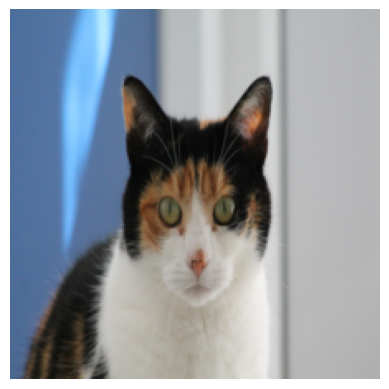

<Figure size 400x400 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def show(img_tensor):
    img = img_tensor.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis("off")
    plt.figure(figsize=(4, 4))

img, label = dataset[10]
show(img)
print("Label:", dataset.classes[label])


## Create train/val split

In [12]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


## Create DataLoaders

In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## Check one batch

In [14]:
images, labels = next(iter(train_loader))

print(images.shape)  # torch.Size([32, 3, 224, 224])
print(labels.shape)  # torch.Size([32])
# row_indices = torch.argmax(out, dim=1) for accuracy


torch.Size([32, 3, 224, 224])
torch.Size([32])


## Visualize images in a grid

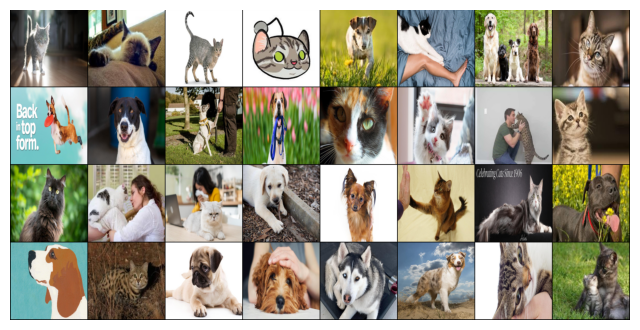

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Create grid
grid = make_grid(images, nrow=8)   # 4 images per row

# Convert from Tensor (C,H,W) → (H,W,C)
grid_np = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(8,8))
plt.imshow(grid_np)
plt.axis("off")
plt.show()


## Load pretrained Model (VGG16)

In [16]:
from torchvision.models import vgg16, VGG16_Weights

# model = models.vgg16(weights="IMAGENET1K_V1")

weights = VGG16_Weights.DEFAULT 
model = vgg16(weights=weights)


for param in model.features.parameters():
  param.requires_grad = False



model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Add Your Custom Head

In [17]:
import torch.nn as nn

num_classes = 2

model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)  # final layer
)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Define Loss and Optimizer

⚠ Only the classifier parameters should be optimized

(Because conv layers are frozen)

In [18]:
import torch
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)


In [19]:
def accuracy(out,label):
    preds = torch.argmax(out,dim=1)
    batch_acc= torch.sum(preds == label) / len(label)
    return batch_acc

test = False
if test:
    out = torch.tensor([[0.2,0.8],[0.6,0.4]])
    label = torch.tensor([1,0])
    accuracy(out,label)

In [20]:
for xb , yb in train_loader:
    out = model(xb)
    loss = loss_func(out, yb)
    acc = accuracy(out,yb)
    print(out.shape)
    print(loss)
    print(acc)
    break

torch.Size([32, 2])
tensor(0.6926, grad_fn=<NllLossBackward0>)
tensor(0.5625)


## Simple Training Loop 

In [21]:
def train_model(model,loader,loss_func,accuracy,opt=None):
    losses = []
    accs = []
    total_samples = 0

    # train mode or eval mode
    if opt is None:
        model.eval()
        torch.set_grad_enabled(False) # to OFF gradients calculation during validation
    else:
        model.train()
        torch.set_grad_enabled(True) # to ON gradients calculation during training

    for xb , yb in loader:
        
        out = model(xb)
        batch_loss = loss_func(out, yb)
        batch_acc = accuracy(out,yb)

        if opt is not None:
            # update classifier parameter
            opt.zero_grad()              # reset gradients
            batch_loss.backward()        # cal gradients
            opt.step()                   # update parameters
            
        batch_size = len(xb)
        losses.append(batch_loss.item() * batch_size)
        accs.append(batch_acc.item() * batch_size)
        total_samples = total_samples + batch_size

    avg_loss = sum(losses) / total_samples
    avg_acc = sum(accs) / total_samples

    torch.set_grad_enabled(True) # ON gradients calculation befor leaving from validation
    return avg_loss, avg_acc

    
        


In [22]:

def fit(model,train_loader,val_loader,loss_func,opt,accuracy,epochs):

  train_losses, train_accs, val_losses, val_accs = [],[],[],[]

  for epoch in range(epochs):
    loss, acc = train_model(model,train_loader,loss_func,accuracy,opt=opt)
    train_losses.append(loss)
    train_accs.append(acc)

    val_loss, val_acc = train_model(model,val_loader,loss_func,accuracy,opt=None,)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    

    print(f"Epoch {epoch+1} Loss: {loss:.4f} Accuracy : {acc} val_Loss: {val_loss:.4f} val_Accuracy : {val_acc}")

  return train_losses, train_accs, val_losses, val_accs


In [23]:
epochs = 3
train_losses, train_accs, val_losses, val_accs = fit(model=model,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     loss_func=loss_func,
                                                     opt=optimizer,
                                                     accuracy=accuracy,
                                                     epochs=epochs)


Epoch 1 Loss: 0.8555 Accuracy : 0.8426966294813691 val_Loss: 0.3614 val_Accuracy : 0.8928571428571429
Epoch 2 Loss: 0.1405 Accuracy : 0.9595505605922656 val_Loss: 0.4567 val_Accuracy : 0.9196428571428571
Epoch 3 Loss: 0.0727 Accuracy : 0.9820224719101124 val_Loss: 0.4052 val_Accuracy : 0.9107142857142857


In [34]:
def plot_metric(lst1:list,lst2:list,xlabel:str,ylabel:str,title:str):
    plt.plot(lst1,"-x",label="train_metric")
    plt.plot(lst2,"-x",label="val_metric")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.Figure(figsize=(5,3))
    plt.show()

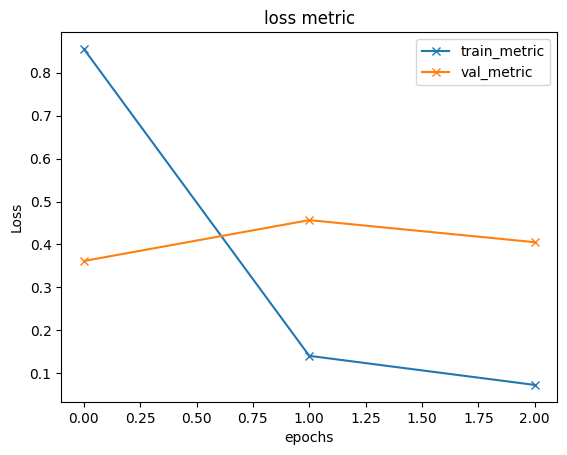

In [35]:
plot_metric(train_losses,val_losses,xlabel="epochs",ylabel="Loss",title="loss metric")

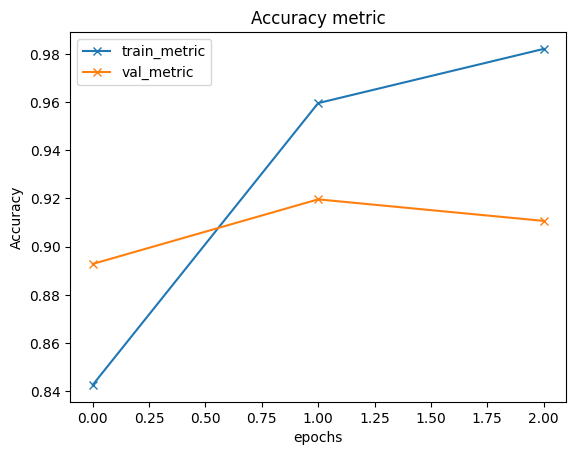

In [36]:
plot_metric(train_accs,val_accs,xlabel="epochs",ylabel="Accuracy",title="Accuracy metric")

## Prediction on test image data

In [27]:
def predict(input_img,label): 
   
   input_batch = input_img.unsqueeze(0)
   out = model(input_batch) # [1,2]
   pred = torch.argmax(out,dim=1).item()
   plt.imshow(input_img.permute(1,2,0))
   # label = test_dataset.classes[label]
   # pred = test_dataset.classes[pred]
   print(f"Actual class : {label} | Predicted class : {pred}")






In [28]:
dataset.class_to_idx

{'cats': 0, 'dogs': 1}

Actual class : 1 | Predicted class : 1


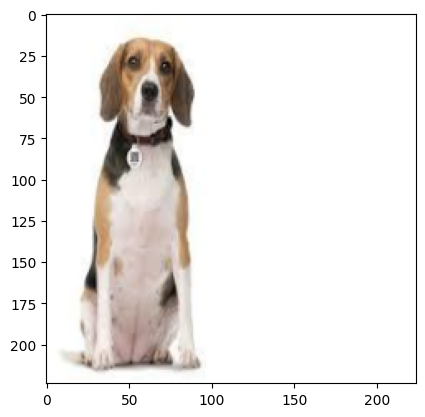

In [29]:
predict(*train_dataset[5])

Actual class : 0 | Predicted class : 0


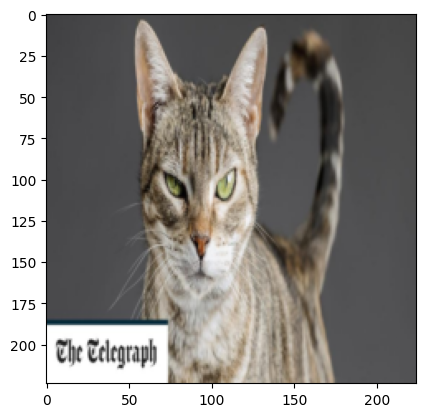

In [30]:
predict(*train_dataset[21])

## Full prediction code

from torchvision import transforms

import torch

model.eval()

# load image

img = Image.open("test.jpg").convert("RGB")

# same transforms as training

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

img = transform(img)

# add batch dimension

img = img.unsqueeze(0)   # (1, 3, 224, 224)

with torch.no_grad():

    output = model(img)

# predicted class index

pred = torch.argmax(output, dim=1).item()

print("Predicted class:", pred)

print("Class name:", dataset.classes[pred])
